In [1]:
from pandas_datareader import data
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import re

In [2]:
linkedin = pd.read_csv('temp_datalab_records_linkedin_company.csv', low_memory=False)

In [3]:
companies = linkedin.company_name.unique()

In [4]:
# Find companies where hiring is most predictive of stock prices.
# function for getting stock prices for a given company
def stock(symbol, start, end):
    # get the stock
    f = web.DataReader(symbol, 'iex', start, end)
    return f

# function for pulling out company linkedin data
def companyli(company):
    df = linkedin[linkedin.company_name==company]
    return df[['as_of_date','employees_on_platform']]

# function for getting the symbol
def symbol(name):
    symbols = get_nasdaq_symbols()
    symbols = symbols[symbols['Security Name'].str.contains(name)]
    symbols = list(symbols.index.values)
    symbols = list(filter(lambda x: '$' not in x, symbols))
    return symbols

# find the difference in the stock price over time
def diffprice(cs):
    # using closing price
    closing = cs.close
    closing.index = pd.to_datetime(closing.index, format='%Y-%m-%d')
    closing = closing.resample('M').first()
    return pd.DataFrame(closing.diff())

# find the difference in # of employees over time
def diffemployees(cli):
    cli.as_of_date = pd.to_datetime(cli.as_of_date, format='%Y-%m-%d')
    cli = cli.set_index('as_of_date')
    employee = cli.resample('M').first()
    return employee.diff()

# same time frame
def timerange(ediff):
    start = ediff.index.min()
    end = ediff.index.max()
    return start, end

# plot change in # of employees to stock price change
def plotchange(sdiff, ediff):
    scaling = ediff.max()/sdiff.max()
    scaledediff = ediff/scaling
    plt.plot(sdiff)
    plt.plot(scaledediff)
    plt.show()
    
# def linregress(sdiff, ediff):
def linregress(x, y):
    lr = LinearRegression()
    lr.fit(x, y)
    return lr.score(x, y)
# why did the industry change?

In [5]:
# get symbols
compdict = dict.fromkeys(companies)
for k in companies:
    try:
        i = re.search('[^a-zA-Z ]', k).start()
        k = k[:i].rstrip()
    except:
        pass
    s = symbol(k)
    compdict[k] = s

In [6]:
# select one symbol
compdict['Goldman Sachs'] = ['GS']

In [37]:
# look at each company and calculate the linear regression

r2 = np.zeros(companies.shape)
validcomp = []
c = 0
totmem = 0
for k in compdict.keys():
    if (compdict[k] is not None) and (len(compdict[k]) == 1):
        # get employee count from linkedin
        emp = companyli(k)
        if emp.shape[0] > 0:
            diffemp = diffemployees(emp)

            # get the timerange
            start, end = timerange(diffemp)

            # get stock difference
            sym = compdict[k][0]
            st = stock(sym, start, end)
            totmem += st.memory_usage().sum()
            diffst = diffprice(st)

            # remove nan
            y = diffemp[1:]
            # get the same timerange
            x = diffst[1:]

            if (x.shape[0] > 4) and (y.isnull().values.sum() == 0):
                # stock data is smaller than the employee data
                y = y.loc[x.index.min():x.index.max()]

                # get r2 value
                r2[c] = linregress(x, y)
                # get the name of the company
                validcomp.append(k)
                c += 1
                
                # save
                df = y.join(x)
                df.to_csv('deltastem/' + k +'.csv', index=True)

In [43]:
# convert from bytes to megabytes
(totmem+linkedin.memory_usage().sum())*10**-6

304.74742399999997

In [48]:
r2 = r2[r2>0]

In [50]:
# save
df = pd.DataFrame(validcomp, columns=['names'])
df['r2'] = r2
df.to_csv('deltastemr2.csv', index=False)

In [77]:
df = df.sort_values(by=['r2'], ascending=False)
c = list(df.names)

In [124]:
temp = pd.read_csv('deltastem/' + c[6] + '.csv')

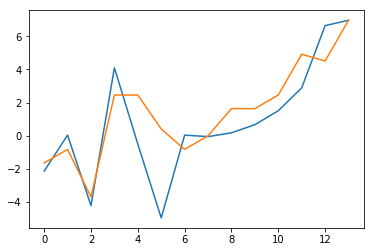

In [126]:
# plot the differences in stock value to employee number fluxuations
plotchange(temp.close, temp.employees_on_platform)

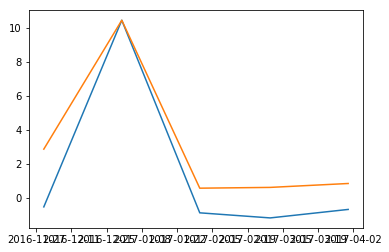

In [118]:
k = c[1]
emp = companyli(k)

diffemp = diffemployees(emp)

# get the timerange
start, end = timerange(diffemp)

# get stock difference
sym = compdict[k][0]
st = stock(sym, start, end)
totmem += st.memory_usage().sum()
diffst = diffprice(st)

# remove nan
y = diffemp[1:]
# get the same timerange
x = diffst[1:]
plotchange(x.close, y.employees_on_platform)

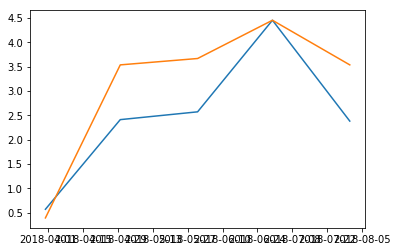

In [117]:
k = c[3]
emp = companyli(k)

diffemp = diffemployees(emp)

# get the timerange
start, end = timerange(diffemp)

# get stock difference
sym = compdict[k][0]
st = stock(sym, start, end)
totmem += st.memory_usage().sum()
diffst = diffprice(st)

# remove nan
y = diffemp[1:]
# get the same timerange
x = diffst[1:]
plotchange(x.close, y.employees_on_platform)

In [153]:
highr2 = df[df['r2']>0.5].names
highr2 = list(highr2)
len(highr2)

13

In [163]:
ind = []
for i in range(len(highr2)):
    ind.extend(list(linkedin[linkedin.company_name==highr2[i]].industry.unique()))

In [166]:
linkedin.industry.value_counts()

Banking                                 168364
Biotechnology                           152710
Financial Services                      148143
Oil & Energy                            116830
Retail                                   95384
Pharmaceuticals                          92107
Information Technology and Services      85066
Computer Software                        83214
Real Estate                              81195
Internet                                 75450
Telecommunications                       63897
Medical Devices                          63717
Semiconductors                           58060
Electrical/Electronic Manufacturing      55538
Insurance                                55291
Utilities                                51601
Automotive                               49154
Mining & Metals                          45272
Restaurants                              38666
Consumer Goods                           36615
Chemicals                                35177
Hospital & He